# Lab: Shrinkage Methods

This chapter follows closely chapter 6 of James et al. (2023).

In [7]:
pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 74.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 88.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 27.7 MB/s  0:00:16m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 32.0 MB/s  0:00:12m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 77.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 53.3 MB/s  0:00:016m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 8.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 32.0 MB/s  0:00:12m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 43.2 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.5 MB/s  0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
pip install "numpy<2.0" 

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


We again collect the new imports
needed for this lab.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
#!pip install l0bnb
#from l0bnb import fit_path


When we talk about big data, we do not only talk about larger sample size ($n$), but also about a larger number of dependant variables ($p$). However, with OLS, we are limited by the identification constraint that $p<n$. In addition, we would like to have $p$ way smaller than $n$ for inference and prediction accuracy.


This lab presents methods to use a least squares fit in a setting in which the number of dependent variables,$p$, is large with respect to the sample size, $n$. 


## Shrinkage methods

Model selection methods constrained the number of varaibles *before* running a linear regression. Shrinkage methods try to run a linear regression while constraining the number of covariates/predictor variables. In particular they penalize high values of the parameters in the objective function resulting in shrunken coefficients.

We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.
 
We will  apply shrinkage methods to the  `Hitters` 
data.  We wish to predict a baseball player’s `Salary` on the
basis of various statistics associated with performance in the
previous year.

First of all, we note that the `Salary` variable is missing for
some of the players.  The `np.isnan()`  function can be used to
identify the missing observations. It returns an array
of the same shape as the input vector, with a `True` for any elements that
are missing, and a `False` for non-missing elements.  The
`sum()`  method can then be used to count all of the
missing elements.

In [12]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()


59

In [13]:
Hitters.shape

(322, 20)

 We see that `Salary` is missing for 59 players. The
`dropna()`  method of data frames removes all of the rows that have missing
values in any variable (by default --- see  `Hitters.dropna?`).
Note: we are dropping the missing, but it is not always the best option. For instance in case of differential attrition.

In [14]:
Hitters = Hitters.dropna();
Hitters.shape


(263, 20)

We will fit the biggest model, using all the variables. Here we excluded the first column corresponding to the intercept, since the methods we will use will fit the intercept separately:

In [15]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)


## Shrinkage methods



### Ridge Regression

Recall that the Ridge Regression objective function is: 
$$ \hat{\beta}^{R}= arg min_{\beta} \sum_{i=1}^{n}(y_{i} - \beta_{0} - \sum_{j=1}^{p} \beta_{j}x_{ij})^2 + \lambda \sum_{j=1}^p \beta^{2}_{j}  = RSS + \lambda \sum_{j=1}^p \beta^{2}_{j} $$
with $\lambda>0$ is a tuning parameter regulating the penalties applied on large parameter.


We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use
`skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture;  ridge regression
corresponds to `l1_ratio=0`.
It is good practice to standardize the columns of `X` in these applications, why? The main reason is that if variables are measured in different units, those with higher values could be perceived as having higher contributions to the model while it is not the case. Since `skl.ElasticNet()` **does not do normalization**, we have to take care of that ourselves.

Since we standardize first, in order to find coefficient
estimates on the original scale, we must *unstandardize*
the coefficient estimates. The parameter $\lambda$ in $RSS + \lambda \sum^{p}_{j=1}\beta^{2}_{j}$ (Ridge 6.5) and $RSS + \lambda \sum^{p}_{j=1}| \beta_{j}| $ (Lasso 6.7) is called `alphas` in `sklearn`. In order to
be consistent with the rest of this chapter, we use `lambdas`
rather than `alphas` in what follows. 

In [16]:
#Standardize in the first 3 rows
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
#Compute the lambdas
lambdas = 10**np.linspace(8, -2, 100) / Y.std() #Creates a logarithmic grid between 10**8/sd(Y) et 10**−2/sd(Y).
#Apply ridge regression
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape


(19, 100)

Here we extract the array of coefficients corresponding to the solutions along the regularization path.

By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  

So here we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [17]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas)) #use neg log to have a readable and intuitive scale later in the graph.
soln_path.index.name = 'negative log(lambda)' #positive values of lambda (higher penalization) have negative values of negative log lambda and conversely. 
soln_path


AtBat        Hits      HmRun       Runs        RBI  \
negative log(lambda)                                                            
-12.310855              0.000800    0.000889   0.000695   0.000851   0.000911   
-12.078271              0.001010    0.001122   0.000878   0.001074   0.001150   
-11.845686              0.001274    0.001416   0.001107   0.001355   0.001451   
-11.613102              0.001608    0.001787   0.001397   0.001710   0.001831   
-11.380518              0.002029    0.002255   0.001763   0.002158   0.002310   
...                          ...         ...        ...        ...        ...   
 9.784658            -290.823989  336.929968  37.322686 -59.748520 -26.507086   
 10.017243           -290.879272  337.113713  37.431373 -59.916820 -26.606957   
 10.249827           -290.923382  337.260446  37.518064 -60.051166 -26.686604   
 10.482412           -290.958537  337.377455  37.587122 -60.158256 -26.750044   
 10.714996           -290.986528  337.470648  37.642077 -60.243522 -26.800522   

                           Walks      Years      CAtBat      CHits     CHmRun  \
negative log(lambda)                                                            
-12.310855              0.000900   0.000812    0.001067   0.001113   0.001064   
-12.078271              0.001135   0.001025    0.001346   0.001404   0.001343   
-11.845686              0.001433   0.001293    0.001698   0.001772   0.001694   
-11.613102              0.001808   0.001632    0.002143   0.002236   0.002138   
-11.380518              0.002281   0.002059    0.002704   0.002821   0.002698   
...                          ...        ...         ...        ...        ...   
 9.784658             134.855915 -17.216195 -387.775826  89.573601 -12.273926   
 10.017243            134.900549 -17.108041 -388.458404  89.000707 -12.661459   
 10.249827            134.936136 -17.022194 -388.997470  88.537380 -12.971603   
 10.482412            134.964477 -16.954081 -389.423414  88.164178 -13.219329   
 10.714996            134.987027 -16.900054 -389.760135  87.864551 -13.416889   

                           CRuns        CRBI      CWalks  League[N]  \
negative log(lambda)                                                  
-12.310855              0.001141    0.001149    0.000993  -0.000029   
-12.078271              0.001439    0.001450    0.001253  -0.000037   
-11.845686              0.001816    0.001830    0.001581  -0.000046   
-11.613102              0.002292    0.002309    0.001995  -0.000058   
-11.380518              0.002892    0.002914    0.002517  -0.000073   
...                          ...         ...         ...        ...   
 9.784658             476.079273  257.271255 -213.124780  31.258215   
 10.017243            477.031349  257.966790 -213.280891  31.256434   
 10.249827            477.791860  258.523025 -213.405740  31.254958   
 10.482412            478.398404  258.967059 -213.505412  31.253747   
 10.714996            478.881540  259.321007 -213.584869  31.252760   

                      Division[W]    PutOuts    Assists     Errors  \
negative log(lambda)                                                 
-12.310855              -0.000390   0.000609   0.000052  -0.000011   
-12.078271              -0.000492   0.000769   0.000065  -0.000014   
-11.845686              -0.000621   0.000970   0.000082  -0.000017   
-11.613102              -0.000784   0.001224   0.000104  -0.000022   
-11.380518              -0.000990   0.001544   0.000131  -0.000028   
...                           ...        ...        ...        ...   
 9.784658              -58.457857  78.761266  53.622113 -22.208456   
 10.017243             -58.448850  78.761240  53.645147 -22.198802   
 10.249827             -58.441682  78.761230  53.663357 -22.191071   
 10.482412             -58.435983  78.761230  53.677759 -22.184893   
 10.714996             -58.431454  78.761235  53.689152 -22.179964   

                      NewLeague[N]  
negative log(lambda)                
-12.310855

We plot the paths to get a sense of how the coefficients vary with $\lambda$.
To control the location of the legend we first set `legend` to `False` in the
plot method, adding it afterward with the `legend()` method of `ax`.

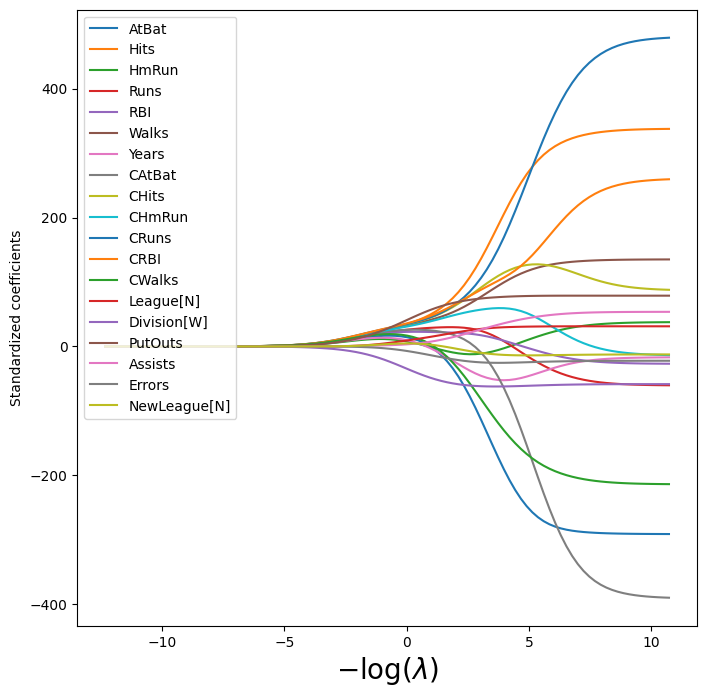

In [18]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=10)
ax.legend(loc='upper left');


(We have used `latex` formatting in the horizontal label, in order to format the Greek $\lambda$ appropriately.) 
We expect the coefficient estimates to be much smaller, in terms of
$\ell_2$ norm, when a large value of $\lambda$ is used, as compared to
when a small value of $\lambda$ is used. (Recall that the  $\ell_2$ norm is the square root of the sum of squared coefficient values.) We display  the coefficients at the $40$th step,
where $\lambda$ is 25.535.

In [19]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat


(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

Let’s compute the $\ell_2$ norm of the standardized coefficients.

In [20]:
np.linalg.norm(beta_hat)


24.170617201443775

In contrast, here is the $\ell_2$ norm when $\lambda$ is 2.44e-01.
Note the much larger $\ell_2$ norm of the
coefficients associated with this smaller value of $\lambda$.

In [21]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)


(0.2437476613348855, 160.42371017725927)

Above we normalized `X` upfront, and fit the ridge model using `Xs`.
The `Pipeline()`  object
in `sklearn` provides a clear way to separate feature
normalization from the fitting of the ridge model itself.

In [22]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.2437476613348855, l1_ratio=0))])

We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [24]:
np.linalg.norm(ridge.coef_)


160.42371017725912

 Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before. 


In [ ]:
dir(ridge)

In [32]:
print(ridge.coef_)

[-13.41340311  59.91051939  -5.29571294  29.6584166   22.02939114
  46.24639176 -11.47518234  22.71849222  51.62233576  43.25498655
  52.36507445  54.56041213  -8.12630545  17.74298859 -53.45807592
  62.50067954  10.39473746 -16.70228091   0.55787883]


### Estimating Test Error of Ridge Regression
Choosing an *a priori* value of $\lambda$ for ridge regression is
difficult if not impossible. We will want to use the validation method
or cross-validation to select the tuning parameter.

We fix the random state of the splitter
so that the results obtained will be reproducible.

In [33]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=17092023)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


array([147613.45831137])

The test MSE is 1.47e+05.  Note
that if we had instead simply fit a model with just an intercept, we
would have predicted each test observation using the mean of the
training observations. We can get the same result by fitting a ridge regression model
with a *very* large value of $\lambda$. Note that `1e10`
means $10^{10}$.

In [34]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


array([203351.3961087])

Obviously choosing $\lambda=0.01$ is arbitrary,  so we will  use cross-validation or the validation-set
approach to choose the tuning parameter $\lambda$.
The object `GridSearchCV()`  allows exhaustive
grid search to choose such a parameter.

We first use the validation set method
to choose $\lambda$.

In [36]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=1.241684227628628, l1_ratio=0))])

Alternatively, we can use 5-fold cross-validation.

In [38]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

grid = skm.GridSearchCV(pipe, 
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.011852477631442489, l1_ratio=0))])

We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

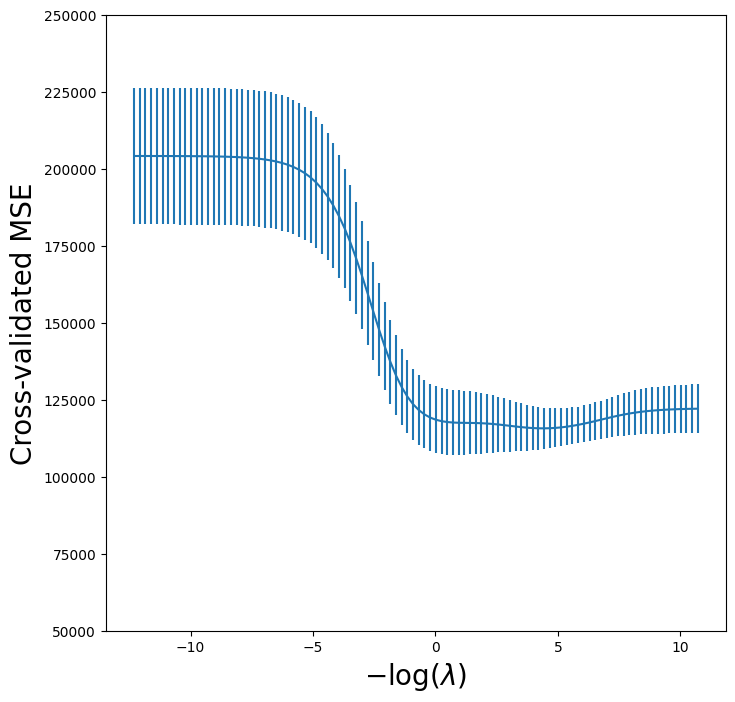

In [39]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


One can cross-validate different metrics to choose a parameter. The default
metric for `skl.ElasticNet()` is test $R^2$.
Let’s compare $R^2$ to MSE for cross-validation here.

In [40]:
grid_r2 = skm.GridSearchCV(pipe, 
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Finally, let’s plot the results for cross-validated $R^2$.

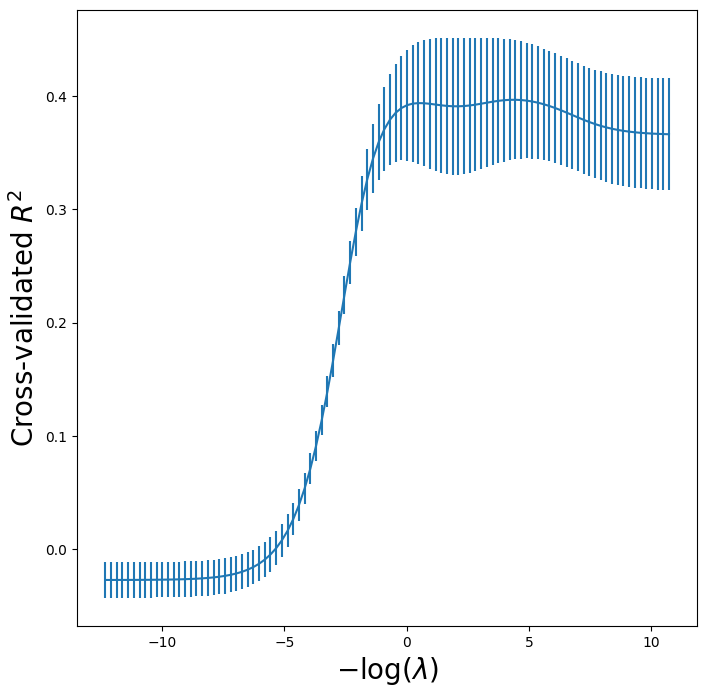

In [41]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


### Fast Cross-Validation for Solution Paths
The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path*. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. 

Even with identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [42]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

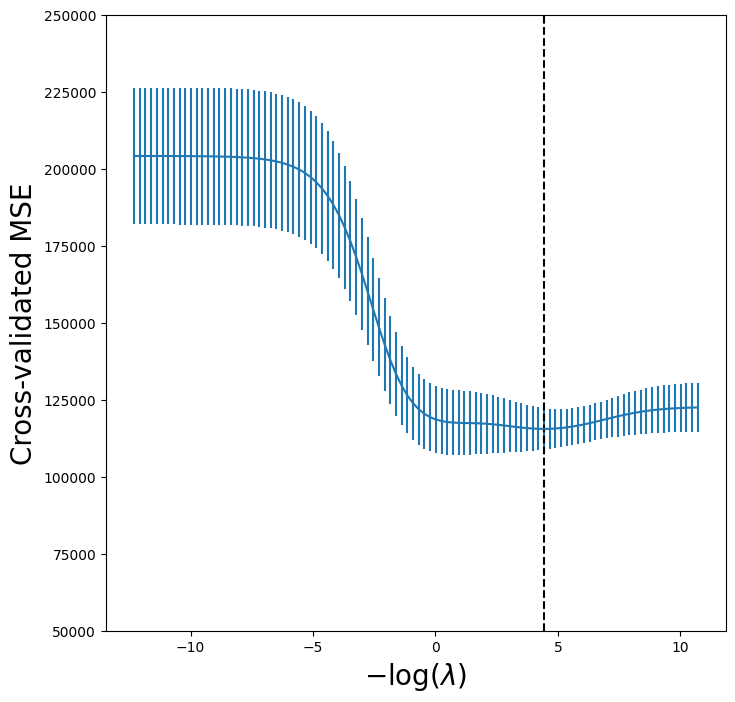

In [43]:
tuned_ridge = pipeCV.named_steps['ridge'] #Calls the ridge step in pipeCV
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.115e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [44]:
np.min(tuned_ridge.mse_path_.mean(1))


115526.70630987734

Note: In this line of code the function `np.min()` returns the lowest value of the MSE for all values of $\lambda$ in our search grid.

This represents a further improvement over the test MSE that we got
using $\lambda=0.01$.  Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [45]:
tuned_ridge.coef_


array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

As expected, none of the coefficients are zero—ridge regression does
not perform variable selection!

### Evaluating Test Error of Cross-Validated Ridge
Choosing $\lambda$ using cross-validation provides a single regression
estimator, similar to fitting a linear regression model. It is therefore reasonable to estimate what its test error is. 

We run into a problem here in that cross-validation will have
*touched* all of its data in choosing $\lambda$, hence we have no
further data to estimate test error.

A compromise is to do an initial
split of the data into two disjoint sets: a training set and a test set.
We then fit a cross-validation
tuned ridge regression on the training set, and evaluate its performance on the test set.

We might call this cross-validation nested
within the validation set approach. A priori there is no reason to use
half of the data for each of the two sets in validation. Below, we use
75% for training and 25% for test, with the estimator being ridge
regression tuned using 5-fold cross-validation.  This can be achieved
in code as follows:

In [46]:
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);


In [47]:
results = skm.cross_validate(pipeCV, 
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']


array([132393.84003227])

### The Lasso

Lasso coefficients minimize the following objective function: 

   $$ \beta_{L}= arg min_{\beta} \sum_{i=1}^{n}(y_{i} - \beta_{0} - \sum_{j=1}^{p} \beta_{j}x_{ij})^2 + \lambda \sum_{j=1}^p |\beta_{j}| $$

A consequence of this objective function is that Lasso is much more likely to shrink coefficients to exactly zero, performing variable selection. 



We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [48]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


3.1472370031649866

In [49]:
lambdas, soln_array = skl.Lasso.path(Xs, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))


We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

In [50]:
soln_path

AtBat        Hits      HmRun       Runs        RBI  \
-5.542369    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.472594    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.402819    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.333043    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.263268    0.000000    0.000000   0.000000   0.000000   0.000000   
...               ...         ...        ...        ...        ...   
 1.086285 -292.618320  330.147359  25.671504 -49.562410 -13.598973   
 1.156060 -292.511837  330.496934  26.317012 -50.124459 -14.357879   
 1.225835 -292.413043  330.823484  26.918970 -50.648775 -15.065567   
 1.295611 -292.320279  331.127368  27.480414 -51.137572 -15.725645   
 1.365386 -292.233620  331.410616  28.004031 -51.593383 -16.341255   

                Walks      Years      CAtBat      CHits  CHmRun       CRuns  \
-5.542369    0.000000   0.000000    0.000000   0.000000     0.0    0.000000   
-5.472594    0.000000   0.000000    0.000000   0.000000     0.0    0.000000   
-5.402819    0.000000   0.000000    0.000000   0.000000     0.0    0.000000   
-5.333043    0.000000   0.000000    0.000000   0.000000     0.0    6.545671   
-5.263268    0.000000   0.000000    0.000000   0.000000     0.0   13.727251   
...               ...        ...         ...        ...     ...         ...   
 1.086285  130.583914 -24.123416 -286.579896  31.226178    -0.0  452.829429   
 1.156060  130.849065 -23.603337 -294.116322  37.120221    -0.0  453.537777   
 1.225835  131.096456 -23.118630 -301.141293  42.613785    -0.0  454.198913   
 1.295611  131.327039 -22.666199 -307.697118  47.741074    -0.0  454.814838   
 1.365386  131.542049 -22.244172 -313.812112  52.523743    -0.0  455.389090   

                 CRBI      CWalks  League[N]  Division[W]    PutOuts  \
-5.542369    0.000000    0.000000  -0.000000    -0.000000   0.000000   
-5.472594   17.205159    0.000000  -0.000000    -0.000000   0.000000   
-5.402819   33.250748    0.000000  -0.000000    -0.000000   0.000000   
-5.333043   42.024827    0.000000  -0.000000    -0.000000   0.000000   
-5.263268   49.189007    0.000000  -0.000000    -0.000000   0.000000   
...               ...         ...        ...          ...        ...   
 1.086285  229.229316 -209.493673  28.373513   -58.125944  79.096546   
 1.156060  229.848245 -209.616048  28.584855   -58.145706  79.080585   
 1.225835  230.425310 -209.730604  28.781925   -58.164143  79.065724   
 1.295611  230.963666 -209.836915  28.965748   -58.181330  79.051835   
 1.365386  231.465779 -209.935936  29.137191   -58.197357  79.038876   

             Assists     Errors  NewLeague[N]  
-5.542369   0.000000  -0.000000     -0.000000  
-5.472594   0.000000  -0.000000     -0.000000  
-5.402819   0.000000   0.000000     -0.000000  
-5.333043   0.000000   0.000000      0.000000  
-5.263268   0.000000   0.000000      0.000000  
...              ...        ...           ...  
 1.086285  49.338699 -20.820927     -9.515995  
 1.156060  49.655372 -20.923792     -9.725398  
 1.225835  49.950637 -21.019700     -9.920665  
 1.295611  50.226081 -21.109174    -10.102799  
 1.365386  50.482980 -21.192625    -10.272666  

[100 rows x 19 columns]

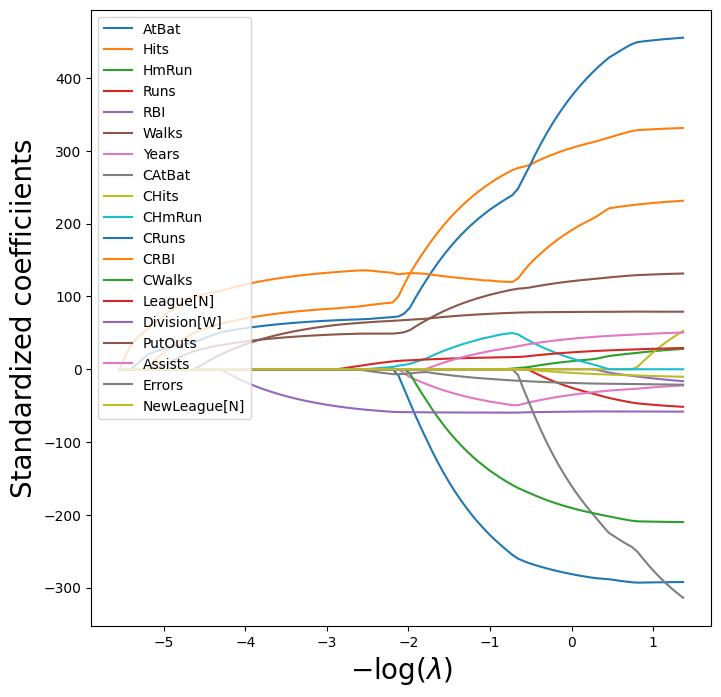

In [51]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression  with $\lambda$ chosen by cross-validation.

In [52]:
np.min(tuned_lasso.mse_path_.mean(1))


114690.73118253695

Let’s again produce a plot of the cross-validation error.


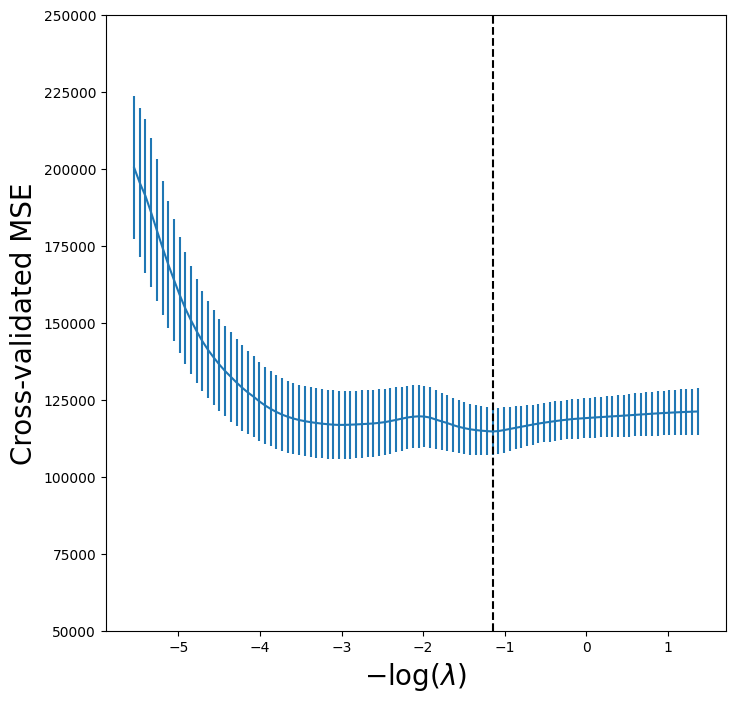

In [53]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are **sparse**. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [54]:
tuned_lasso.coef_


array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. 